In [2]:
import os
import librosa
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
working_OS = 'Windows'

if working_OS == 'MacOS':
    os.chdir(r"/Users/jordanlee/Code/School/CSCI416/music-genre-classification")
    print("Current Working Directory:", os.getcwd())

elif working_OS == 'Windows':
    os.chdir(r"C:\Code\School\CSCI416\music_genre_classification\music-genre-classification")
    print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Code\School\CSCI416\music_genre_classification\music-genre-classification


# Raw Data Test

In [33]:
# Load the CSV
data_path = 'data/features/augmented_features.csv'
df = pd.read_csv(data_path)

# Strip brackets and convert to float where applicable
for col in df.columns:
    if df[col].dtype == 'object':  # Check if the column is a string
        try:
            df[col] = df[col].str.strip('[]').astype(float)  # Remove brackets and convert to float
        except ValueError:
            print(f"Skipping column '{col}' as it contains non-numeric data.")

# Save the cleaned data back to CSV (optional)
df.to_csv('data/features/aug_features_cleaned.csv', index=False)

Skipping column 'label' as it contains non-numeric data.


In [4]:
df = pd.read_csv('data/features/aug_features_cleaned.csv')

print(df.head())

   length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0  661794          0.349243         0.090267  0.062099  0.000633   
1  661794          0.360839         0.089537  0.088020  0.001352   
2  661794          0.353408         0.087590  0.087666  0.001255   
3  661794          0.361252         0.096059  0.042711  0.000534   
4  661794          0.326704         0.094482  0.061822  0.001287   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             2356.361371          151470.019714              2624.635908   
1             1765.876937          111147.466502              1975.900817   
2             1878.023359          119200.788352              2153.267158   
3             1217.412221          239451.204091              1633.883795   
4             1466.379089          422281.761120              1965.039549   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0            64750.644732   5287.300666  ...   44.90742

In [5]:
X = df.drop(columns=['label'])
y = df['label']

In [6]:
label_encoder =LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [39]:
def optimize_rf_hyperparameters(X, y):
    # Create a pipeline that includes scaling and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(random_state=42))
    ])
    
    # Parameter grid for Random Forest
    param_dist = {
        'rf__n_estimators': [50, 100, 200],
        'rf__max_depth': [None, 10, 20, 30],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 2, 4]
    }
    
    # Randomized search with cross-validation
    random_search = RandomizedSearchCV(
        pipeline, 
        param_distributions=param_dist,
        n_iter=20,
        cv=5,
        scoring='accuracy',
        random_state=42
    )
    
    # Fit on the original X and y (scaling happens inside the pipeline)
    random_search.fit(X, y)
    
    print("Best parameters:", random_search.best_params_)
    print("Best cross-validated score:", random_search.best_score_)
    
    return random_search.best_estimator_

optimize_rf_hyperparameters(X_scaled, y_encoded)

Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': 30}
Best cross-validated score: 0.5919304396215915


Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=30, n_estimators=200,
                                        random_state=42))])

In [9]:
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf= 1, max_depth= 30, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=200, random_state=42)

In [10]:
def optimize_svm_hyperparameters(X, y):
    # Create a pipeline that includes scaling and SVM
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True, random_state=42))
    ])
    
    # Comprehensive parameter grid for SVM
    param_dist = {
        'svm__C': [0.1, 1, 10, 100],  # Regularization parameter
        'svm__kernel': ['rbf', 'linear', 'poly'],  # Kernel types
        'svm__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Kernel coefficient
        'svm__class_weight': [None, 'balanced'],
        'svm__degree': [2, 3, 4]  # For polynomial kernel
    }
    
    # Randomized search with cross-validation
    random_search = RandomizedSearchCV(
        svm_pipeline, 
        param_distributions=param_dist,
        n_iter=20,  # Number of parameter settings to sample
        cv=5,  # 5-fold cross-validation
        scoring='accuracy',
        random_state=42,
        verbose=2  # Show progress
    )
    
    # Fit on the data
    random_search.fit(X, y)
    
    # Print results
    print("Best SVM parameters:", random_search.best_params_)
    print("Best cross-validated score:", random_search.best_score_)
    
    return random_search.best_estimator_

# Usage
best_svm = optimize_svm_hyperparameters(X, y_encoded)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.8s
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.8s
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.8s
[CV] END svm__C=10, svm__class_weight=None, svm__degree=4, svm__gamma=0.001, svm__kernel=poly; total time=   0.8s


KeyboardInterrupt: 

In [11]:
svm_model = SVC(kernel='rbf', gamma= 0.01, degree=4, class_weight='balanced', C=100, probability=True, random_state=42)
svm_model.fit(X_train, y_train)

SVC(C=100, class_weight='balanced', degree=4, gamma=0.01, probability=True,
    random_state=42)

In [59]:
joblib.dump(rf_model, 'models/aug_random_forest_model.joblib')
joblib.dump(svm_model, 'models/aug_svm_model.joblib')

['models/aug_svm_model.joblib']

In [14]:
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.60      0.69        73
           1       0.89      0.93      0.91        69
           2       0.65      0.74      0.69        58
           3       0.81      0.73      0.77        59
           4       0.72      0.72      0.72        53
           5       0.69      0.82      0.75        51
           6       0.82      0.88      0.84        56
           7       0.74      0.89      0.81        57
           8       0.80      0.76      0.78        58
           9       0.79      0.68      0.73        66

    accuracy                           0.77       600
   macro avg       0.77      0.78      0.77       600
weighted avg       0.78      0.77      0.77       600

Accuracy: 0.7716666666666666


In [17]:
y_test.shape

(600,)

In [18]:
y_pred_rf.shape

(600,)

In [61]:
y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.87      0.73      0.79        73
           1       0.95      0.90      0.93        69
           2       0.77      0.86      0.81        58
           3       0.78      0.83      0.80        59
           4       0.78      0.81      0.80        53
           5       0.76      0.94      0.84        51
           6       0.88      0.88      0.88        56
           7       0.91      0.89      0.90        57
           8       0.77      0.83      0.80        58
           9       0.83      0.68      0.75        66

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600

Accuracy: 0.83


In [62]:
label_names = sorted(df['label'].unique())

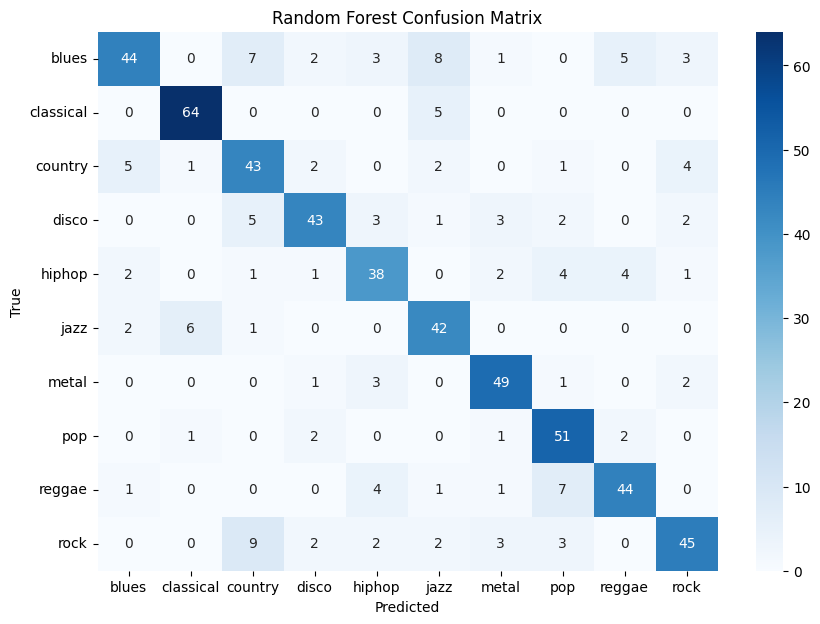

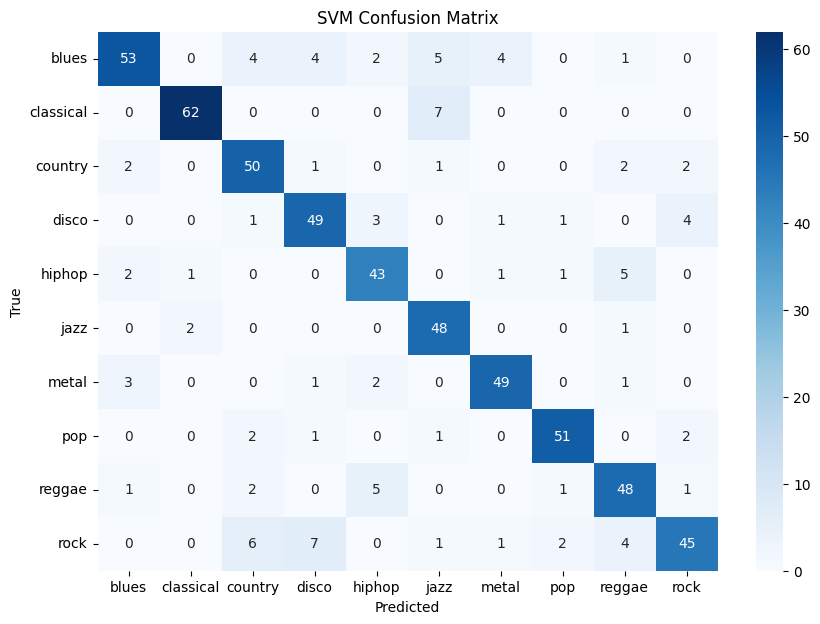

In [63]:
y_pred_rf = rf_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)

# Generate confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix for SVM
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

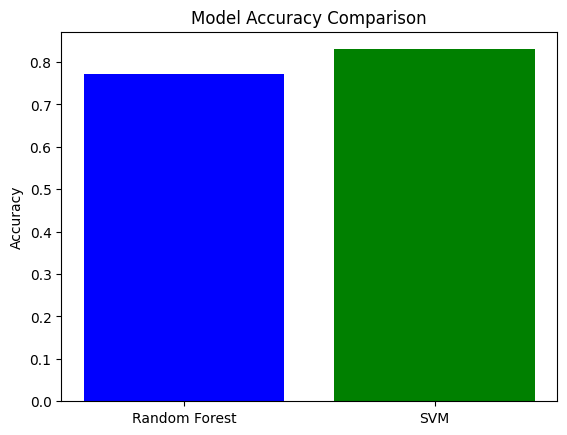

In [64]:
# Calculate accuracy for each model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Create a bar plot for comparison
models = ['Random Forest', 'SVM']
accuracies = [accuracy_rf, accuracy_svm]

plt.bar(models, accuracies, color=['blue', 'green'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

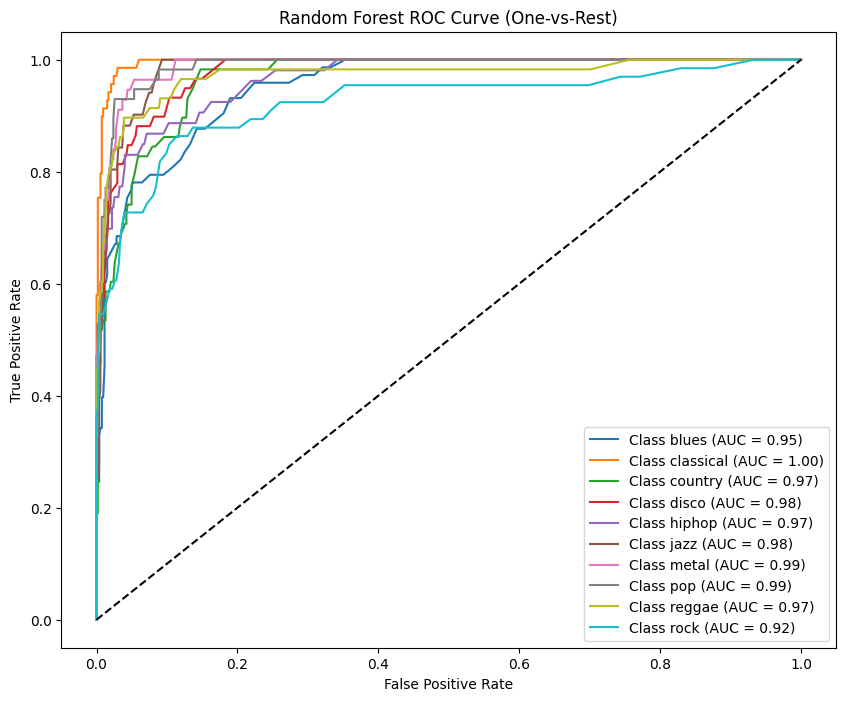

In [65]:
# For Random Forest
n_classes = len(label_names)  # Number of classes (genres)
y_score_rf = rf_model.predict_proba(X_test)  # Get probabilities for each class

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_score_rf[:, i])  # One-vs-Rest
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (One-vs-Rest)')
plt.legend(loc='best')
plt.show()

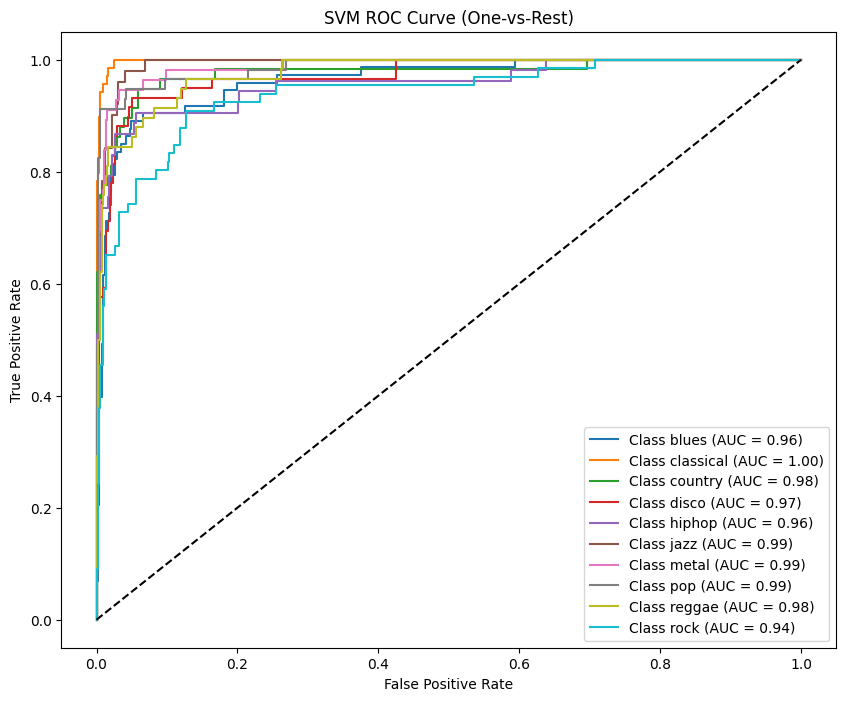

In [66]:
# For SVM
y_score_svm = svm_model.predict_proba(X_test)  # Get probabilities for each class

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_score_svm[:, i])  # One-vs-Rest
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve (One-vs-Rest)')
plt.legend(loc='best')
plt.show()

In [67]:
# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5)
print("Random Forest CV Scores:", cv_scores_rf)

# Cross-validation for SVM
cv_scores_svm = cross_val_score(svm_model, X_train, y_train, cv=5)
print("SVM CV Scores:", cv_scores_svm)

Random Forest CV Scores: [0.73541667 0.78333333 0.78496868 0.77453027 0.76200418]
SVM CV Scores: [0.75208333 0.8        0.78914405 0.77244259 0.77453027]
